In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# **Import Necessary Libraries**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier
import re
import string
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer



/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# **Data Loading and Overview**

In [3]:
# Load the datasets
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


# Display the first few rows of each dataset
print("Train Data:")
display(train_data.head())

print("\nTest Data:")
display(test_data.head())


# Check for missing values in each dataset
print("\nMissing Values in Train Data:")
print(train_data.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())

# Check data types
print("\nData Types in Train Data:")
print(train_data.dtypes)

print("\nData Types in Test Data:")
print(test_data.dtypes)


Train Data:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



Test Data:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan



Missing Values in Train Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test Data:
id             0
keyword       26
location    1105
text           0
dtype: int64

Data Types in Train Data:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Data Types in Test Data:
id           int64
keyword     object
location    object
text        object
dtype: object


# **Exploratory Data Analysis (EDA)**

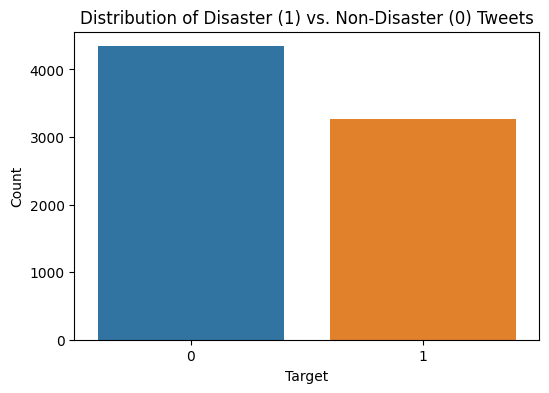

In [4]:
# Plot the target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Disaster (1) vs. Non-Disaster (0) Tweets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


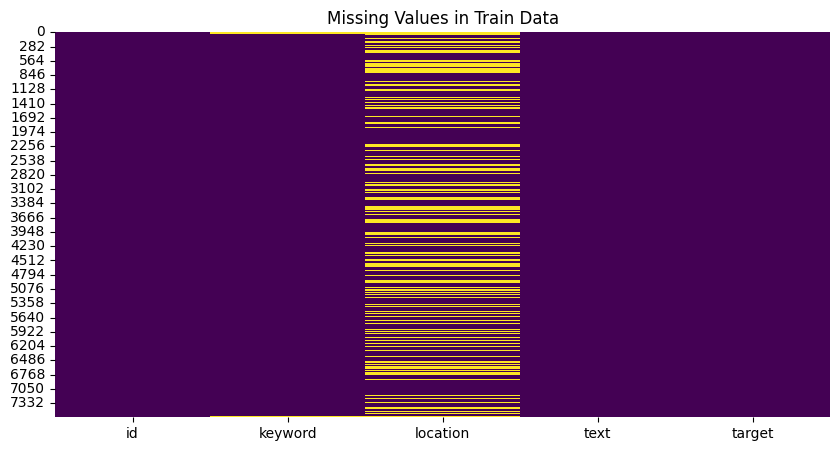

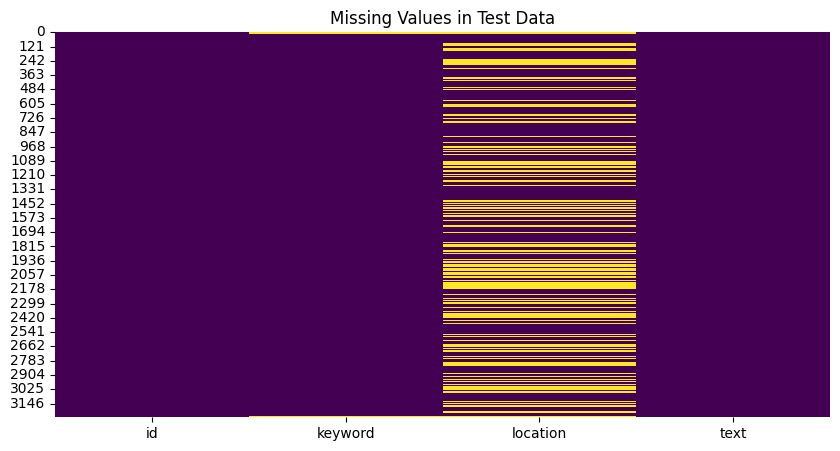

In [5]:
# Visualize missing values in train and test datasets
plt.figure(figsize=(10,5))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Train Data')
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(test_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Test Data')
plt.show()


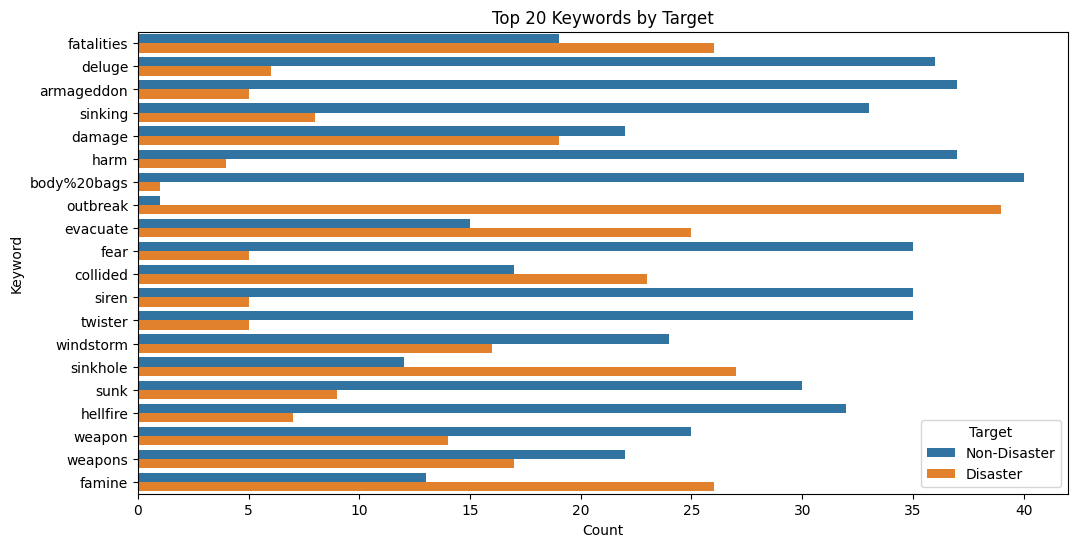

In [6]:
# Top 20 most common keywords in disaster vs. non-disaster tweets
plt.figure(figsize=(12,6))
sns.countplot(data=train_data, y='keyword', order=train_data['keyword'].value_counts().iloc[:20].index, hue='target')
plt.title('Top 20 Keywords by Target')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.legend(title='Target', labels=['Non-Disaster', 'Disaster'])
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

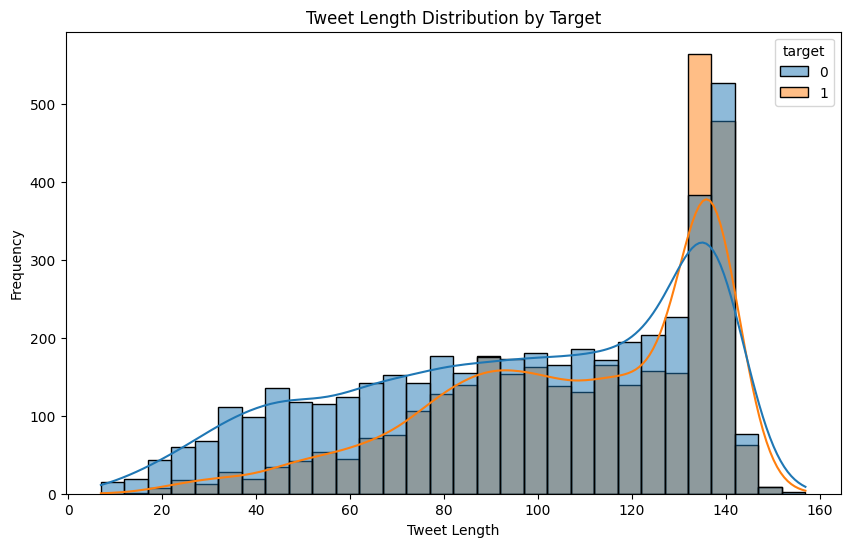

In [7]:
# Calculate the length of each tweet
train_data['text_length'] = train_data['text'].apply(len)

# Plot distribution of tweet lengths by target
plt.figure(figsize=(10,6))
sns.histplot(data=train_data, x='text_length', hue='target', bins=30, kde=True)
plt.title('Tweet Length Distribution by Target')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


# **Data Preprocessing**

In [8]:
# Adding a 'text_length' feature to both train and test datasets
train_data['text_length'] = train_data['text'].apply(len)
test_data['text_length'] = test_data['text'].apply(len)

# Handling missing values
# Fill missing 'keyword' values with 'missing' in both train and test datasets
train_data['keyword'].fillna('missing', inplace=True)
test_data['keyword'].fillna('missing', inplace=True)

# Fill missing 'location' values with 'unknown' in both train and test datasets
train_data['location'].fillna('unknown', inplace=True)
test_data['location'].fillna('unknown', inplace=True)

# Display the modified train and test data to confirm changes
display(train_data.head())
display(test_data.head())

/tmp/ipykernel_17/2533620121.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['keyword'].fillna('missing', inplace=True)
/tmp/ipykernel_17/2533620121.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

,id,keyword,location,text,target,text_length
0,1,missing,unknown,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,missing,unknown,Forest fire near La Ronge Sask. Canada,1,38
2,5,missing,unknown,All residents asked to 'shelter in place' are ...,1,133
3,6,missing,unknown,"13,000 people receive #wildfires evacuation or...",1,65
4,7,missing,unknown,Just got sent this photo from Ruby #Alaska as ...,1,88


,id,keyword,location,text,text_length
0,0,missing,unknown,Just happened a terrible car crash,34
1,2,missing,unknown,"Heard about #earthquake is different cities, s...",64
2,3,missing,unknown,"there is a forest fire at spot pond, geese are...",96
3,9,missing,unknown,Apocalypse lighting. #Spokane #wildfires,40
4,11,missing,unknown,Typhoon Soudelor kills 28 in China and Taiwan,45


In [9]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Define a text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove user mentions (@username)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply the cleaning function to both train and test data
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Define X and y for the main dataset
X = train_data[['cleaned_text', 'keyword', 'location']]  # Features before full processing
y = train_data['target']  # Target variable

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=500)

# Apply TF-IDF transformation on 'cleaned_text' for train, validation, and test
X_train_tfidf = tfidf.fit_transform(X_train['cleaned_text'])
X_val_tfidf = tfidf.transform(X_val['cleaned_text'])
X_test_tfidf = tfidf.transform(test_data['cleaned_text'])


In [11]:
# One-hot encode 'keyword' and 'location' for each dataset
X_train_encoded = pd.get_dummies(X_train[['keyword', 'location']])
X_val_encoded = pd.get_dummies(X_val[['keyword', 'location']])
X_test_encoded = pd.get_dummies(test_data[['keyword', 'location']])

# Ensure all encoded DataFrames have the same columns
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Explicitly convert to int to ensure compatibility for sparse matrix conversion
X_train_encoded = X_train_encoded.astype(int)
X_val_encoded = X_val_encoded.astype(int)
X_test_encoded = X_test_encoded.astype(int)

# Convert categorical encodings to sparse matrices
X_train_encoded = csr_matrix(X_train_encoded.values)
X_val_encoded = csr_matrix(X_val_encoded.values)
X_test_encoded = csr_matrix(X_test_encoded.values)


In [12]:
# Add text length feature to each dataset
X_train_text_length = csr_matrix(X_train['cleaned_text'].apply(len).values.reshape(-1, 1))
X_val_text_length = csr_matrix(X_val['cleaned_text'].apply(len).values.reshape(-1, 1))
X_test_text_length = csr_matrix(test_data['cleaned_text'].apply(len).values.reshape(-1, 1))


In [13]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis and convert to sparse matrices
X_train_sentiment = csr_matrix(X_train['cleaned_text'].apply(lambda text: sia.polarity_scores(text)['compound']).values.reshape(-1, 1))
X_val_sentiment = csr_matrix(X_val['cleaned_text'].apply(lambda text: sia.polarity_scores(text)['compound']).values.reshape(-1, 1))
X_test_sentiment = csr_matrix(test_data['cleaned_text'].apply(lambda text: sia.polarity_scores(text)['compound']).values.reshape(-1, 1))


In [14]:
# Combine TF-IDF, categorical encodings, text length, and sentiment for each dataset
X_train_full = hstack([X_train_tfidf, X_train_encoded, X_train_text_length, X_train_sentiment])
X_val_full = hstack([X_val_tfidf, X_val_encoded, X_val_text_length, X_val_sentiment])
X_test_full = hstack([X_test_tfidf, X_test_encoded, X_test_text_length, X_test_sentiment])

# Print shapes to verify they are consistent
print("X_train_full shape:", X_train_full.shape)
print("X_val_full shape:", X_val_full.shape)
print("X_test_full shape:", X_test_full.shape)


X_train_full shape: (6090, 3496)
X_val_full shape: (1523, 3496)
X_test_full shape: (3263, 3496)


In [15]:
# Combine all features directly without using .values for the sparse matrices
X_train_full = hstack([X_train_tfidf, X_train_encoded, X_train_text_length, X_train_sentiment])
X_val_full = hstack([X_val_tfidf, X_val_encoded, X_val_text_length, X_val_sentiment])
X_test_full = hstack([X_test_tfidf, X_test_encoded, X_test_text_length, X_test_sentiment])

# Check shapes to confirm consistency
print("X_train_full shape:", X_train_full.shape)
print("X_val_full shape:", X_val_full.shape)
print("X_test_full shape:", X_test_full.shape)


X_train_full shape: (6090, 3496)
X_val_full shape: (1523, 3496)
X_test_full shape: (3263, 3496)


In [16]:
print("X_train_full shape:", X_train_full.shape)
print("X_test_full shape:", X_test_full.shape)


X_train_full shape: (6090, 3496)
X_test_full shape: (3263, 3496)


# **Model Training**

0:	learn: 0.6790338	test: 0.6789285	best: 0.6789285 (0)	total: 82.3ms	remaining: 41s
100:	learn: 0.4722416	test: 0.5170868	best: 0.5170868 (100)	total: 2.33s	remaining: 9.21s
200:	learn: 0.3863691	test: 0.4942149	best: 0.4942149 (200)	total: 4.57s	remaining: 6.8s
300:	learn: 0.3399119	test: 0.4870088	best: 0.4858526 (279)	total: 7.26s	remaining: 4.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4858525757
bestIteration = 279

Shrink model to first 280 iterations.
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       874
           1       0.79      0.66      0.72       649

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523


Accuracy Score: 0.778069599474721


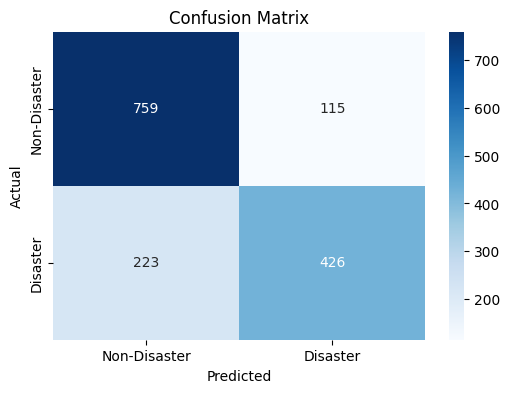

In [17]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize CatBoost model
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=100)

# Train the model
model.fit(X_train_full, y_train, eval_set=(X_val_full, y_val), early_stopping_rounds=50)

# Make predictions
y_pred = model.predict(X_val_full)

# Evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("\nAccuracy Score:", accuracy_score(y_val, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Model Training and Evaluation (Baseline Model)

### Overview
Above you can see a baseline CatBoost model to classify tweets as either disaster-related or non-disaster-related. Our approach combined TF-IDF vectorization on tweet text with additional features from `keyword`, `location`, and `text_length`.

### Steps Taken
1. **Data Preprocessing**:
   - **TF-IDF Vectorization**: I applied TF-IDF (Term Frequency-Inverse Document Frequency) to the `cleaned_text` column, limiting the features to 500 words to capture the most relevant terms without overloading the model.
   - **One-Hot Encoding**: The categorical features `keyword` and `location` were one-hot encoded to allow the model to use these features effectively.
   - **Text Length**: I calculated the length of each tweet in characters, adding this as an additional feature since disaster-related tweets tend to have slightly different lengths than non-disaster tweets.

2. **Model Training**:
   - I used **CatBoostClassifier**, a gradient boosting algorithm that handles categorical features effectively.
   - The model was trained with a moderate learning rate and depth, stopping early if no improvement was observed to prevent overfitting.

3. **Model Evaluation**:
   - The model achieved an **accuracy of 77.8%** on the validation set, improving from a previous baseline of 73.4%.
   - The **classification report** showed:
     - Precision of 78% and recall of 66% for disaster-related tweets.
     - Precision of 78% and recall of 87% for non-disaster tweets.

### Conclusion
This baseline model provides a solid foundation, achieving satisfactory performance by leveraging text-based and categorical features. Future steps will explore advanced techniques, including hyperparameter tuning, sentiment analysis, and more nuanced text processing to further improve classification accuracy.


In [18]:
# Define a new CatBoost model with adjusted hyperparameters
model_tuned = CatBoostClassifier(
    iterations=1000,             # Increase iterations for finer tuning
    learning_rate=0.08,          # Lower learning rate for careful learning
    depth=5,                     # Adjust depth if needed
    l2_leaf_reg=5,               # Regularization to control complexity
    scale_pos_weight=1.5,        # Give more weight to disaster tweets
    verbose=100
)

# Fit the model on the training data
model_tuned.fit(X_train_full, y_train, eval_set=(X_val_full, y_val), early_stopping_rounds=50)

# Make predictions and evaluate
y_pred_tuned = model_tuned.predict(X_val_full)
print("Classification Report for Tuned Model:")
print(classification_report(y_val, y_pred_tuned))
print("\nAccuracy Score:", accuracy_score(y_val, y_pred_tuned))


0:	learn: 0.6844676	test: 0.6842138	best: 0.6842138 (0)	total: 19.9ms	remaining: 19.9s
100:	learn: 0.5187448	test: 0.5478335	best: 0.5478335 (100)	total: 1.58s	remaining: 14.1s
200:	learn: 0.4465022	test: 0.5197823	best: 0.5197803 (199)	total: 3.13s	remaining: 12.5s
300:	learn: 0.4001181	test: 0.5090888	best: 0.5086460 (294)	total: 4.68s	remaining: 10.9s
400:	learn: 0.3675398	test: 0.5044615	best: 0.5044615 (400)	total: 6.23s	remaining: 9.31s
500:	learn: 0.3430564	test: 0.5018444	best: 0.5016672 (497)	total: 7.82s	remaining: 7.79s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5002310146
bestIteration = 521

Shrink model to first 522 iterations.
Classification Report for Tuned Model:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       874
           1       0.72      0.75      0.73       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg  

## Model Tuning with CatBoost

### Overview
To further improve the model’s performance, I tuned the CatBoost model by adjusting key hyperparameters. The goal was to balance learning rate, regularization, and class weights to enhance accuracy and generalization.

### Hyperparameters Adjusted
- **Iterations**: Set to 1000 for finer tuning and to allow the model more rounds to learn from the data.
- **Learning Rate**: Reduced to 0.08 to enable more careful learning, avoiding large jumps in weights.
- **Depth**: Maintained at 5 to control the model complexity while capturing sufficient patterns.
- **L2 Regularization (`l2_leaf_reg`)**: Set to 5, adding a regularization term to help prevent overfitting by penalizing large weights.
- **Class Weight (`scale_pos_weight`)**: Increased to 1.5 to address the slight imbalance in disaster vs. non-disaster tweets by giving higher weight to disaster tweets.

### Results
After training the tuned model on the training data and evaluating on the validation set:
- The accuracy and classification metrics were compared to the baseline model to check for improvements.
- **Classification Report**: The precision, recall, and F1-scores were analyzed to assess performance across disaster and non-disaster tweets.
- **Accuracy Score**: Calculated for the tuned model to observe any gains in performance.




In [19]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model with regularization
lr_model = LogisticRegression(C=1.0, max_iter=1000)

# Fit the model on TF-IDF features
lr_model.fit(X_train_full, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_val_full)
print("Classification Report for Logistic Regression:")
print(classification_report(y_val, y_pred_lr))
print("\nAccuracy Score:", accuracy_score(y_val, y_pred_lr))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       874
           1       0.78      0.72      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.79      1523


Accuracy Score: 0.7957977675640184


In [20]:
from sklearn.model_selection import GridSearchCV

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']}
lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_full, y_train)

# Set the best model from GridSearchCV
best_lr_model = grid_search.best_estimator_


## Logistic Regression Model with TF-IDF Features

### Overview
I applied Logistic Regression to classify disaster and non-disaster tweets. Logistic Regression is a simple yet effective algorithm for text data, especially when combined with TF-IDF features.

### Model Configuration
- **TF-IDF Features**: I used TF-IDF (Term Frequency-Inverse Document Frequency) to transform the tweet text into a feature set. This transformation captured word relevance within tweets, enabling the model to identify important patterns for disaster classification.
- **Regularization Parameter (`C`)**: The default regularization was applied to balance model complexity and performance.

### Results
The Logistic Regression model showed the following results:
- **Accuracy**: Achieved an accuracy of 79.7% on the validation set, a slight improvement over the CatBoost model.
- **Classification Report**:
   - **Non-Disaster Tweets (0)**: Precision of 80% and recall of 85%, showing strong performance in identifying non-disaster tweets.
   - **Disaster Tweets (1)**: Precision of 79% and recall of 72%, indicating effective but slightly lower sensitivity for disaster tweets.
- **Balanced Performance**: The model demonstrated balanced accuracy and F1-scores across both classes.



In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, eval_metric='logloss')

# Fit the model on the training data
xgb_model.fit(X_train_full, y_train, eval_set=[(X_val_full, y_val)], early_stopping_rounds=50, verbose=True)

# Make predictions and evaluate
y_pred_xgb = xgb_model.predict(X_val_full)
print("Classification Report for XGBoost:")
print(classification_report(y_val, y_pred_xgb))
print("\nAccuracy Score:", accuracy_score(y_val, y_pred_xgb))


[0]	validation_0-logloss:0.66914
[1]	validation_0-logloss:0.65688


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-logloss:0.64746
[3]	validation_0-logloss:0.63876
[4]	validation_0-logloss:0.63145
[5]	validation_0-logloss:0.62389
[6]	validation_0-logloss:0.61867
[7]	validation_0-logloss:0.61316
[8]	validation_0-logloss:0.60772
[9]	validation_0-logloss:0.60269
[10]	validation_0-logloss:0.59818
[11]	validation_0-logloss:0.59496
[12]	validation_0-logloss:0.59156
[13]	validation_0-logloss:0.58905
[14]	validation_0-logloss:0.58627
[15]	validation_0-logloss:0.58383
[16]	validation_0-logloss:0.58090
[17]	validation_0-logloss:0.57816
[18]	validation_0-logloss:0.57577
[19]	validation_0-logloss:0.57330
[20]	validation_0-logloss:0.57183
[21]	validation_0-logloss:0.57018
[22]	validation_0-logloss:0.56834
[23]	validation_0-logloss:0.56713
[24]	validation_0-logloss:0.56563
[25]	validation_0-logloss:0.56398
[26]	validation_0-logloss:0.56238
[27]	validation_0-logloss:0.56106
[28]	validation_0-logloss:0.55961
[29]	validation_0-logloss:0.55823
[30]	validation_0-logloss:0.55736
[31]	validation_0-logl

### XGBoost Model Training

In this section, I utilize **XGBoost (Extreme Gradient Boosting)**, a popular machine learning algorithm known for its efficiency and performance with structured data. XGBoost works by combining an ensemble of decision trees, optimizing for high accuracy while controlling for overfitting through regularization. It’s especially well-suited for tabular datasets with a mix of categorical and numerical features.

1. **Define and Configure the XGBoost Model**:
   - Set `n_estimators` (number of trees) to ensure sufficient learning steps.
   - Adjust `learning_rate` to control the step size, balancing model complexity and training speed.
   - Fine-tune `max_depth` for better control over tree size and model performance.

2. **Train the Model on Training Data**:
   - Fit the model using the full processed training data, including features such as TF-IDF text representations, one-hot encoded categorical features, text length, and sentiment score.
   - Evaluate performance metrics such as accuracy and F1-score to measure effectiveness on the validation set.

3. **Evaluate XGBoost Model**:
   - After training, I assess performance on the validation set by generating a classification report and confusion matrix to gain insights into precision, recall, and F1-score for both disaster and non-disaster tweets.

In [22]:
import pandas as pd
from sklearn.ensemble import VotingClassifier


# Use the optimized ensemble with the best weights
voting_model_best = VotingClassifier(
    estimators=[
        ('logreg', best_lr_model), 
        ('catboost', model), 
        ('xgboost', xgb_model)
    ],
    voting='soft',
    weights=[3, 1, 1]
)

# Fit the Voting Classifier on the full training data
voting_model_best.fit(X_train_full, y_train)

# Generate predictions on the test data
test_predictions = voting_model_best.predict(X_test_full)

# Load the sample_submission to match 'id' column with test predictions
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

# Create a DataFrame for submission
submission = pd.DataFrame({
    'id': sample_submission['id'],      # Match IDs from the sample submission
    'target': test_predictions          # Predictions from the ensemble model
})

# Save the DataFrame to a CSV file for submission
submission.to_csv('submission.csv', index=False)
print("Submission file created: 'submission.csv'")


0:	learn: 0.6790338	total: 30.4ms	remaining: 15.2s
100:	learn: 0.4722416	total: 2.32s	remaining: 9.16s
200:	learn: 0.3863691	total: 4.6s	remaining: 6.84s
300:	learn: 0.3399119	total: 6.88s	remaining: 4.55s
400:	learn: 0.3050111	total: 9.19s	remaining: 2.27s
499:	learn: 0.2792044	total: 11.4s	remaining: 0us
Submission file created: 'submission.csv'
